In [3]:
# Load dependencies:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from scipy import optimize, constants, stats
import matplotlib.patches as mpatches
# -*- coding: utf-8 -*-

In [2]:
import math as mt
import pandas as pd

def invertArray(col_arr):
    res = [[] for i in range(len(col_arr[0]))]
    for c in range(len(col_arr)):
        for r in range(len(col_arr[0])):
            res[r].append(col_arr[c][r])
    return res


def getCommaIndex(inpt_str):
    commaInd_inpt = -1
    for i in range(len(inpt_str)):
        commaInd_inpt = i if inpt_str[i] == '.' else commaInd_inpt
    if commaInd_inpt ==-1:
        commaInd_inpt = len(inpt_str) - 1
    return commaInd_inpt

def sig_format(inpt, err, sig_dgts, smallDigits = True):
    pot = 0
    if smallDigits and (np.abs(inpt) < 10**(-3) or np.abs(err) < 10**(-3)):
        pot = mt.ceil(np.max([0, -mt.log10(np.abs(inpt)) if inpt != 0 else 0, -mt.log10(np.abs(err)) if err != 0 else 0]))
        inpt *= 10**pot
        err *= 10**pot
    err_str = str(err)
    isSig = False
    lastSigInd = 0
    sigToGo = sig_dgts
    commaInd = -1
    for i in range(len(err_str)):
        if isSig == False and not err_str[i] in ['0', '.']:
            isSig = True
            if err_str[i] in ['1', '2'] and sig_dgts == 1:
                sigToGo += 1

        if err_str[i] == '.':
            commaInd = i
        else:
            sigToGo -= isSig
        if sigToGo > 0:
            lastSigInd += 1

    if sigToGo > 0:
        sig_dgts -= 1
        lastSigInd -= 1
    if commaInd == -1:
        commaInd = len(err_str)
    commaInd = commaInd if commaInd != -1 else len(err_str)
    dec_pot = - lastSigInd + commaInd - (lastSigInd < commaInd)
    err = err * 10**(-dec_pot)
    err = mt.ceil(err)
    err_str = str(err * 10**(dec_pot))
    if lastSigInd > commaInd:
        err_str = err_str[:lastSigInd + 1]

    inpt *= 10**(-dec_pot)
    inpt_str = str(round(inpt) * 10**dec_pot)
    commaInd_inpt = getCommaIndex(inpt_str)

    if len(inpt_str) - 1 - commaInd_inpt != -dec_pot:
        inpt_str += '0'
    commaInd_inpt = getCommaIndex(inpt_str)


    inpt_str = inpt_str[:commaInd_inpt - dec_pot + 1]
    if commaInd_inpt - dec_pot + 1 < commaInd_inpt:
        inpt_str += " \cdot 10^{" + str(dec_pot - 1) +"}"
    inpt_str = inpt_str

    if pot != 0:
        inpt_str += ("\cdot 10^{" + str(-pot) + "}" if pot != 0 else "")
        err_str += ("\cdot 10^{" + str(-pot) + "}" if pot != 0 else "")
    return inpt_str, err_str




#IMPORTANT NOTE: CANT HANDLE SIGNIFICANT 0 AS LAST DIGIT! (for example error 0.10 will be treated as 0.1)

def sigFormatTable(arr, val_err_indices, sig_digits = 1, int_cols = []):
    res = [["undefined" for k in range(len(arr[i]))] for i in range(len(arr))]
    trashCan = []
    for i in range(len(arr)):
        for j in val_err_indices:
            if i == j[0]:
                for k in range(len(arr[i])):
                    fmt = sig_format(arr[i][k], arr[j[1]][k], sig_digits)
                    res[i][k] =  "$ " + fmt[0] + " \pm " + fmt[1]
                    if arr[i][k] != 0:
                        res[i][k] += "\: (\pm " + sig_format(0, np.abs(100.0 * arr[j[1]][k]/arr[i][k]), 2, smallDigits=False)[1] + "\%)"
                    res[i][k] += "$"
                trashCan.append(j[1])
                break
        if res[i][0] == "undefined":
            for k in range(len(arr[i])):
                if i in int_cols:
                   res[i][k] = "$ " + str(int(arr[i][k])) + "$"
                else:
                    res[i][k] = "$ " + sig_format(arr[i][k], arr[i][k], sig_digits)[0] + "$"


    for e in trashCan:
        res.pop(e)
        for i in range(len(trashCan)):
            if trashCan[i] > e:
                trashCan[i] = trashCan[i] - 1
    return res


def sig_format_str(inpt, err, sig_dgts):
    err_str = str(err)
    isSig = False
    lastSigInd = 0
    sigToGo = sig_dgts
    commaInd = -1
    for i in range(len(err_str)):
        if isSig == False and not err_str[i] in ['0', '.']:
            isSig = True
            if err_str[i] in ['1', '2'] and sig_dgts == 1:
                sigToGo += 1

        if err_str[i] == '.':
            commaInd = i
        else:
            sigToGo -= isSig
        if sigToGo > 0:
            lastSigInd += 1

    if sigToGo > 0:
        sig_dgts -= 1
        lastSigInd -= 1
    if commaInd == -1:
        commaInd = len(err_str)
    commaInd = commaInd if commaInd != -1 else len(err_str)
    dec_pot = - lastSigInd + commaInd - (lastSigInd < commaInd)
    err = float(err) * 10**(-dec_pot)
    err = mt.ceil(err)

    err_str = ('{0:.%df}' % (-dec_pot)).format(err * 10**(dec_pot))
    if lastSigInd > commaInd:
        err_str = err_str[:lastSigInd + 1]

    inpt = float(inpt) * 10**(-dec_pot)
    inpt_str = ('{0:.%df}' % (-dec_pot)).format(round(inpt) * 10**dec_pot)
    commaInd_inpt = getCommaIndex(inpt_str)

    if len(inpt_str) - 1 - commaInd_inpt != -dec_pot:
        inpt_str += '0'
    commaInd_inpt = getCommaIndex(inpt_str)


    inpt_str = inpt_str[:commaInd_inpt - dec_pot + 1]
    if commaInd_inpt - dec_pot + 1 < commaInd_inpt:
        inpt_str += " \cdot 10^{" + str(dec_pot - 1) +"}"
    inpt_str = inpt_str
    return inpt_str, err_str


#IMPORTANT NOTE: CANT HANDLE SIGNIFICANT 0 AS LAST DIGIT! (for example error 0.10 will be treated as 0.1)

def asLatex(arr, col_labels, dontInvert = False):
    df = pd.DataFrame(invertArray(arr), columns=col_labels) if not dontInvert else pd.DataFrame(arr, columns = col_labels)
    cformate = "|"
    for i in df.columns:
        cformate += "l|"

    res = """\\begin{table}[]\n
    \t\centering\n
    \t\caption{CHANGE THIS LATER}\n\t""" + df.style.hide(axis="index").to_latex(column_format=cformate, hrules = True).replace("toprule", "hline").replace("\n", "\n\t\t") + "\t\label{tab:my_label}\n" + "\end{table}"
    res = res.replace("midrule", "hline")
    return res.replace("bottomrule", "hline")

def printTable(arr, col_labels):
    df = pd.DataFrame(invertArray(arr), columns=col_labels)
    print(df.to_markdown())

def showTable(arr, col_labels):
    df = pd.DataFrame(invertArray(arr), columns=col_labels)
    display(df)

def weightedMiddle(arr, err_arr):
    val = 0
    err = 0
    for i in range(len(arr)):
        val += arr[i]/err_arr[i]**2
        err += 1/err_arr[i]**2

    return val/err, np.sqrt(1/err)

def indexOf(arr):
    return range(len(arr))


class Fit:
    def __init__(self, slope, intercept, sigSlope, sigIntercept, chiSquared):
        self.slope = slope
        self.intercept = intercept
        self.sigSlope = sigSlope
        self.sigIntercept = sigIntercept
        self.chiSquared = chiSquared

    def __str__(self):
        res = "$m = " + sig_format(self.slope, self.sigSlope, 1)[0] + "\pm" + sig_format(self.slope, self.sigSlope, 1)[1]
        if self.slope != 0:
            res += "(\pm" + sig_format(0, self.sigSlope/self.slope, 2, smallDigits=False)[1] + "\%)"
        res += "$\n$b = " + sig_format(self.intercept, self.sigIntercept, 1)[0] + "\pm" + sig_format(self.intercept, self.sigIntercept, 1)[1]
        if self.intercept != 0:
            res += "(\pm" + sig_format(0, self.sigIntercept/self.intercept, 2, smallDigits=False)[1] + "\%)"
        res += "$\n$\chi^2 = " + self.chiSquared + "$"
        return res

def linReg(xdata, ydata, yerr = None):
    if yerr == None:
        yerr = [1 for i in ydata]
    if len(xdata) != len(ydata):
        print(" :( Error :( : xdata and ydata are ment to resemble pairs of (x,y)-Values. Thisfor, xdata and ydata need to have the same dimension. Since thats currently not the case, I assume very much, that you messed up. Sorry for that, happy bug-fixing...")
    delta = 0

    oneOverSig2 = 0
    x2overSig2 = 0
    xOverSig2 = 0
    xyOverSig2 = 0
    yOverSig2 = 0
    for i in indexOf(xdata):
        oneOverSig2 += 1/yerr[i]**2
        x2overSig2 += xdata[i]**2/yerr[i]**2
        xOverSig2 += xdata[i]/yerr[i]**2
        xyOverSig2 += xdata[i] * ydata[i]/yerr[i]**2
        yOverSig2 += ydata[i]/yerr[i]**2

    Delta = oneOverSig2 * x2overSig2 - xOverSig2**2
    m = 1/Delta * (oneOverSig2 * xyOverSig2 - xOverSig2 * yOverSig2)
    b = 1/Delta * (x2overSig2 * yOverSig2 - xOverSig2 * xyOverSig2)
    sigM = (1/Delta * oneOverSig2)**(0.5)
    sigB = (1/Delta * x2overSig2)
    chi2 = 0
    for i in indexOf(xdata):
        chi2 += (1/yerr[i] * ydata[i] - m * xdata[i] - b)**2

    return Fit(m, b, sigM, sigB, chi2)

In [ ]:
def filterForIndex(val, modify_clbck, newLabels = []):

        #Modify data:
    collumns_mod = [[] for d in range(len(collumns))]
    mod_labels = labels.copy()
    for i in range (len(collumns[0])):
        for d in range(len(collumns)):
            if d in mod_collumns:
                collumns_mod[d].append(modify_clbck(d, i))
            else:
                collumns_mod[d].append(collumns[d][i])

    cntr = 0
    for d in mod_collumns:
        if cntr < len(newLabels):
            mod_labels[d] = newLabels[cntr]
            cntr += 1

    #whitelist values with certain value:
    if True:
        good_value = val
        g_indices = []
        for e in range(len(collumns_mod[0])):
            if collumns_mod[0][e] == good_value:
                g_indices.append(e)
        res = [[] for l in range(len(collumns_mod))]
        for i in g_indices:
            for d in range(len(collumns_mod)):
                res[d].append(collumns_mod[d][int(i)])

    return res, mod_labels

In [4]:
#Latex Setup:
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{xfrac, amsmath}'
plt.rcParams['font.size'] =  14
plt.rcParams['axes.labelsize'] = 25
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['errorbar.capsize'] = 5

In [5]:
#Load Data:
inputfile = "data/file.csv"

collumns = []
labels = []
readLast = True
d = 0

while readLast:
    try:
        collumns.append(np.loadtxt(inputfile, usecols = d, delimiter=";",unpack = True, skiprows = 1))
        labels.append(np.loadtxt(inputfile, usecols = d, delimiter = ";", dtype = str)[0])
        d += 1

    except Exception as e:
        print("Error while reading collumn", d, ": ",e)
        readLast = False

del d

print("\n\nREAD", len(collumns), "COLUMNS!\n\n")

collumns.append([0.1 for i in collumns[2]])
labels.append("sigma_B in G")

output = ""
for l in labels:
    output += l + "\t"
print(output)
for i in range(len(collumns[0])):
    print(i, ":\t")
    output = ""
    for d in range(len(collumns)):
        output += str(collumns[d][i]) + ", "
    output = output[:len(output)-2]
    print(output, "\n")
    del output

collumns.append([0.5 for val in collumns[1]])

Error while reading collumn 3 :  invalid column index 3 at row 1 with 3 columns


READ 3 COLUMNS!


Spulenr.	Abstand $z$ von der Spulenmitte in cm	B in G (Gauss)	sigma_B in G	
0 :	
1.0, 0.0, 46.3, 0.1 

1 :	
1.0, 1.0, 46.2, 0.1 

2 :	
1.0, 2.0, 46.1, 0.1 

3 :	
1.0, 3.0, 46.1, 0.1 

4 :	
1.0, 4.0, 46.0, 0.1 

5 :	
1.0, 5.0, 46.0, 0.1 

6 :	
1.0, 6.0, 45.9, 0.1 

7 :	
1.0, 7.0, 45.8, 0.1 

8 :	
1.0, 8.0, 45.8, 0.1 

9 :	
1.0, 9.0, 45.7, 0.1 

10 :	
1.0, 10.0, 45.6, 0.1 

11 :	
1.0, 11.0, 45.5, 0.1 

12 :	
1.0, 12.0, 45.3, 0.1 

13 :	
1.0, 13.0, 45.2, 0.1 

14 :	
1.0, 14.0, 45.1, 0.1 

15 :	
1.0, 15.0, 44.8, 0.1 

16 :	
1.0, 16.0, 44.5, 0.1 

17 :	
1.0, 17.0, 44.2, 0.1 

18 :	
1.0, 18.0, 43.5, 0.1 

19 :	
1.0, 19.0, 42.8, 0.1 

20 :	
1.0, 20.0, 41.9, 0.1 

21 :	
1.0, 21.0, 41.0, 0.1 

22 :	
1.0, 22.0, 39.9, 0.1 

23 :	
1.0, 23.0, 38.9, 0.1 

24 :	
1.0, 24.0, 38.2, 0.1 

25 :	
1.0, 25.0, 37.4, 0.1 

26 :	
1.0, 26.0, 36.9, 0.1 

27 :	
1.0, 27.0, 36.5, 0.1 

28 :	
2.0, 0.0, 44.2, 0.1 

29 :

'sigma_B in G'

In [6]:
print(asLatex(sigFormatTable(collumns, [[2, 3], [1, len(collumns)-1]], int_cols = [0]), labels))

\begin{table}[]

    	\centering

    	\caption{CHANGE THIS LATER}
	\begin{tabular}{|l|l|l|}
		\hline
		Spulenr. & Abstand $z$ von der Spulenmitte in cm & B in G (Gauss) \\
		\hline
		$ 1$ & $ 0\cdot 10^{-1} \pm 5\cdot 10^{-1}$ & $ 46.3 \pm 0.1\: (\pm 0.22\%)$ \\
		$ 1$ & $ 1.0 \pm 0.5\: (\pm 50\%)$ & $ 46.2 \pm 0.1\: (\pm 0.22\%)$ \\
		$ 1$ & $ 2.0 \pm 0.5\: (\pm 25\%)$ & $ 46.1 \pm 0.1\: (\pm 0.22\%)$ \\
		$ 1$ & $ 3.0 \pm 0.5\: (\pm 17\%)$ & $ 46.1 \pm 0.1\: (\pm 0.22\%)$ \\
		$ 1$ & $ 4.0 \pm 0.5\: (\pm 13\%)$ & $ 46.0 \pm 0.1\: (\pm 0.22\%)$ \\
		$ 1$ & $ 5.0 \pm 0.5\: (\pm 10\%)$ & $ 46.0 \pm 0.1\: (\pm 0.22\%)$ \\
		$ 1$ & $ 6.0 \pm 0.5\: (\pm 8.4\%)$ & $ 45.9 \pm 0.1\: (\pm 0.22\%)$ \\
		$ 1$ & $ 7.0 \pm 0.5\: (\pm 7.2\%)$ & $ 45.8 \pm 0.1\: (\pm 0.22\%)$ \\
		$ 1$ & $ 8.0 \pm 0.5\: (\pm 6.3\%)$ & $ 45.8 \pm 0.1\: (\pm 0.22\%)$ \\
		$ 1$ & $ 9.0 \pm 0.5\: (\pm 5.6\%)$ & $ 45.7 \pm 0.1\: (\pm 0.22\%)$ \\
		$ 1$ & $ 10.0 \pm 0.5\: (\pm 5.0\%)$ & $ 45.6 \pm 0.1\: (\pm 0.22\%)$ \\


In [7]:
def load(file):
        #Load Data:
    inputfile_r = file

    collumns_r = []
    labels_r = []
    readLast_r = True
    d_r = 0

    while readLast_r:
        try:
            collumns_r.append(np.loadtxt(inputfile_r, usecols = d_r, delimiter=";",unpack = True, skiprows = 1))
            labels_r.append(np.loadtxt(inputfile_r, usecols = d_r, delimiter = ";", dtype = str)[0])
            d_r += 1

        except Exception as e_r:
            readLast_r = False

    del d_r
    return collumns_r, labels_r

In [8]:
#Modify data:
collumns_mod = [[] for d in range(len(collumns))]
d_x = 1#TODO
d_val = 2#TODO
d_err = 3#TODO
mod_collumns = [d_val, d_err] #TODO
allIndices = []#TODO
paramFile = "data/metadata.csv"

In [9]:
def modifyCols(d, i):
    return collumns[d][i]

In [10]:
for d in allIndices:
    lbl, arr = filterForIndex(d, modifyCols, ["New Label for first Col in collumns_mod"])#TODO
    lbl_2 = lbl.copy()
    print(asLatex(sigFormatTable(arr, [[d_val, d_err]], int_cols = [0]), lbl))#TODO

\begin{table}[]

    	\centering

    	\caption{CHANGE THIS LATER}
	\begin{tabular}{|l|l|l|}
		\hline
		Spulenr. & Abstand $z$ von der Spulenmitte in cm & $H$ in $\frac{\text{A}}{\text{m}}$ \\
		\hline
		$ 1$ & $ 0\cdot 10^{-1} \pm 5\cdot 10^{-1}$ & $ 3684 \pm 8\: (\pm 0.22\%)$ \\
		$ 1$ & $ 1.0 \pm 0.5\: (\pm 50\%)$ & $ 3676 \pm 8\: (\pm 0.22\%)$ \\
		$ 1$ & $ 2.0 \pm 0.5\: (\pm 25\%)$ & $ 3669 \pm 8\: (\pm 0.22\%)$ \\
		$ 1$ & $ 3.0 \pm 0.5\: (\pm 17\%)$ & $ 3669 \pm 8\: (\pm 0.22\%)$ \\
		$ 1$ & $ 4.0 \pm 0.5\: (\pm 13\%)$ & $ 3661 \pm 8\: (\pm 0.22\%)$ \\
		$ 1$ & $ 5.0 \pm 0.5\: (\pm 10\%)$ & $ 3661 \pm 8\: (\pm 0.22\%)$ \\
		$ 1$ & $ 6.0 \pm 0.5\: (\pm 8.4\%)$ & $ 3653 \pm 8\: (\pm 0.22\%)$ \\
		$ 1$ & $ 7.0 \pm 0.5\: (\pm 7.2\%)$ & $ 3645 \pm 8\: (\pm 0.22\%)$ \\
		$ 1$ & $ 8.0 \pm 0.5\: (\pm 6.3\%)$ & $ 3645 \pm 8\: (\pm 0.22\%)$ \\
		$ 1$ & $ 9.0 \pm 0.5\: (\pm 5.6\%)$ & $ 3637 \pm 8\: (\pm 0.22\%)$ \\
		$ 1$ & $ 10.0 \pm 0.5\: (\pm 5.0\%)$ & $ 3629 \pm 8\: (\pm 0.22\%)$ \\
		

In [11]:
def anotherFormula(param1, sig1, param2, sig2):#TODO
    res = param1 * param2
    sig = np.sqrt(sig1**2 * param2**2 + sig2**2 * param2**2)
    return res, sig

In [12]:
#Define a funktion that returns your expected Result in dependence of various parameters and x:
def formula(param1, sig1, param2, sig2):#TODO
    res = param1 + param2
    sig = np.sqrt(sig1**2 + sig2**2)
    return res, sig

In [13]:
def generalFormula(x, sigX, y, sigY, useFormula):#TODO
    if useFormula:
        return formula(x, sigX, y, sigY)
    return anotherFormula(x, sigX, y, sigY)

In [14]:
def analyse_offset(ind, output = False):
    #Create fit:
    metadata = load(paramFile)[0]
    #set known parameters:
    collumns_mod, lbls = filterForIndex(ind, modifyCols)
    param1 = collumns_mod[0] #TODO
    sig1 = collumns_mod[1] #TODO
    param2 = collumns_mod[2] #TODO
    sig2 = collumns_mod[3] #TODO
    useFormula = coil[4]#TODO

    vals = [(collumns_mod[d_val][i_r] - generalFormula(param1, sig1, param2, sig2, useFormula)[0]) for i_r in range(len(collumns_mod[d_x]))]
    errs = [np.sqrt(collumns_mod[d_err][i_r]**2 + generalFormula(param1, sig1, param2, sig2)[1]**2) for i_r in range(len(collumns_mod[d_x]))]

    the_vals = [(generalFormula(param1, sig1, param2, sig2)[0]) for i_r in range(len(collumns_mod[d_x]))]
    the_errs = [(generalFormula(param1, sig1, param2, sig2)[1]) for i_r in range(len(collumns_mod[d_x]))]
    if output:
        print("Index", ind)
        print(asLatex(sigFormatTable([collumns_mod[d_val], collumns_mod[d_err], the_vals, the_errs, vals, errs], [[0, 1], [2,3], [4,5]]), ["Gemessener Wert", "Erwarteter Wert", "$\Delta$"]))

    if ind == someIndexWithoutOffset:#TODO
        return [0, 0]
    return weightedMiddle(vals, errs)

In [15]:
middleOffset = weightedMiddle([analyse_offset(i, output = True)[0] for i in allIndices], [analyse_offset(i)[1] for i in allIndices])
print("middle: ", middleOffset[0], "\pm", middleOffset[1], "(\pm", middleOffset[1]/middleOffset[0])

someNotedOffset = 9999999 #TODO
someNotedOffsetsError = 9999999999 #TODO
print("noted Offset:", someNotedOffset, "\pm", someNotedOffsetsError, "(\pm", someNotedOffsetError/someNotedOffset,"\%)")

Spule 1
\begin{table}[]

    	\centering

    	\caption{CHANGE THIS LATER}
	\begin{tabular}{|l|l|l|}
		\hline
		Gemessene Feldstärke $H\sub m$ & Erwartete Feldstärke $H\sub{e}$ & $\Delta H = H\sub m - H\sub e$ \\
		\hline
		$ 3684 \pm 8\: (\pm 0.22\%)$ & $ 890 \pm 40\: (\pm 4.1\%)$ & $ 2790 \pm 40\: (\pm 1.4\%)$ \\
		$ 3676 \pm 8\: (\pm 0.22\%)$ & $ 890 \pm 40\: (\pm 4.1\%)$ & $ 2790 \pm 40\: (\pm 1.4\%)$ \\
		$ 3669 \pm 8\: (\pm 0.22\%)$ & $ 890 \pm 40\: (\pm 4.1\%)$ & $ 2780 \pm 40\: (\pm 1.4\%)$ \\
		$ 3669 \pm 8\: (\pm 0.22\%)$ & $ 890 \pm 40\: (\pm 4.1\%)$ & $ 2780 \pm 40\: (\pm 1.4\%)$ \\
		$ 3661 \pm 8\: (\pm 0.22\%)$ & $ 890 \pm 40\: (\pm 4.1\%)$ & $ 2770 \pm 40\: (\pm 1.4\%)$ \\
		$ 3661 \pm 8\: (\pm 0.22\%)$ & $ 890 \pm 40\: (\pm 4.1\%)$ & $ 2770 \pm 40\: (\pm 1.4\%)$ \\
		$ 3653 \pm 8\: (\pm 0.22\%)$ & $ 880 \pm 40\: (\pm 4.1\%)$ & $ 2770 \pm 40\: (\pm 1.4\%)$ \\
		$ 3645 \pm 8\: (\pm 0.22\%)$ & $ 880 \pm 40\: (\pm 4.1\%)$ & $ 2760 \pm 40\: (\pm 1.4\%)$ \\
		$ 3645 \pm 8\: (

In [16]:
offsts = [[1, 2, 3], [analyse_offset(i)[0] for i in [1, 2, 3]], [analyse_offset(i)[1] for i in [1, 2, 3]]]
offsts[0].append(-12345678910987654321)
offsts[1].append(middleOffset[0])
offsts[2].append(middleOffset[1])
offsts[0].append(-12345678910987654321)
offsts[1].append(someNotedOffset)
offsts[2].append(someNotedOffsetError)
print(asLatex(sigFormatTable(offsts, [[1, 2]], int_cols=[0]), ["Index", "Offset"]).replace("$ -1$", "Gewichtetes Mittel").replace("$ -2$", "Notierter Offset"))

\begin{table}[]

    	\centering

    	\caption{CHANGE THIS LATER}
	\begin{tabular}{|l|l|}
		\hline
		Spule & Offset \\
		\hline
		$ 1$ & $ 2743 \pm 7\: (\pm 0.25\%)$ \\
		$ 2$ & $ 2749 \pm 7\: (\pm 0.24\%)$ \\
		$ 3$ & $ 2550 \pm 50\: (\pm 1.8\%)$ \\
		Gewichtetes Mittel & $ 2744 \pm 5\: (\pm 0.17\%)$ \\
		Notierter Offset & $ 2825 \pm 8\: (\pm 0.29\%)$ \\
		\hline
		\end{tabular}
			\label{tab:my_label}
\end{table}


In [17]:
def analyse_fit(ind):
    coil = load(paramFile)[0]
    lbls, collumns_mod = filterForIndex(ind, modifyCols)
    param1 = coil[0]
    sig1 = coil[1]
    param2 = coil[2]
    sig2 = coil[3]
    useFormula = coil[4]
    ret = optimize.curve_fit((lambda x, a_p, b_p, c_p: a_p*generalFormula(param1 - c_p, sig1, param2, sig2, useFormula)[0] + b_p), xdata=collumns_mod[d_x], ydata =[float(collumns_mod[d_val][i] - analyse_offset(ind)[0]) for i in range(len(collumns_mod[d_val]))], p0 = [1, 0, 1], sigma=[np.sqrt(err**2 + analyse_offset(d)[1]**2) for err in collumns_mod[d_err]], absolute_sigma=True)#TODO
    #result = stats.linregress([generalFormula(param1, sig1, param2, sig2)[0] for param1 in collumns_mod[d_x]]], [val - analyse_offset(ind)[0] for val in collumns_mod[d_val]])
    #ret = [[result.slope, result.intercept], [result.stderr, result.intercept_stderr]]
    return ret[0], np.sqrt(np.diag(ret[1]))

In [18]:
#Define function to set up Figure-Environment:
def create_fig(fig_size=(12, 7.5)): # die Figurengröße wird standardmäßig auf (12, 7.5) inches gesetzt (width, height)
    fig, axes = plt.subplots(figsize=fig_size) # Unterabbildung und Achsen erstellen
    axes = plt.gca() # Das aktuelle Achsenobjekt bekommen, um es zu verändern
    axes.tick_params(axis = 'both', labelsize = 'large') # Größe der Tickstriche an den Seiten anpassen
    axes.grid(which = 'major', color = '#CCCCCC', linestyle = '--') # Alle N Einheiten eine große Linie in Grau (#CCCCCC) die aus "--" besteht
    axes.grid(which = 'minor', color = '#CCCCCC', linestyle = ':')  # Zwischen allen großen Linien M kleine Linie in Grau (#CCCCCC) die aus ":" bestehen
    axes.xaxis.set_minor_locator(AutoMinorLocator(5)) # Nach wie vielen Einheiten soll eine große Linie erstellt werden
    axes.yaxis.set_minor_locator(AutoMinorLocator(5)) # Wie viele kleine Linien sollen zwischen zwei großen erstellt werden
    axes.ticklabel_format(style = 'sci', axis = 'both', scilimits = (-3, 3), useMathText = True) # Wenn die Wert auf einer Achse größer als 1e{+/- 3} werden, werden diese in Wissenschaftlicher Notation angezeigt
    return fig, axes # Das Figuren- und Achsenobjekt zurückgeben, damit es weiter angepasst werden kann

In [19]:
def createValues(coil_ind, lowerBorder, upperBorder):
    coil = load(paramFile)[0]
    lbls, collumns_mod = filterForIndex(coil_ind, modifyCols)
    param1 = coil[0]
    sig1 = coil[1]
    param2 = coil[2]
    sig2 = coil[3]
    useFormula = coil[4]
    #create fit-values
    fitParams, sig_fitParams = analyse_fit(coil_ind)
    values = [[], [], []]
    values[0] = np.linspace(lowerBorder, upperBorder, 20000)
    values[2] = generalFormula(values[0], sig1, param2, sig2, useFormula)[0]
    values[1] = fitParams[0] * generalFormula(values[0] - fitParams[1], sig1, param2, sig2, useFormula)[0] + fitParams[1] #TODO
    print("Index", coil_ind, ":", fitParams, "\pm", fitParams)
    #modify values:
    values_mod = [[] for d in values]

    for i_r in range(len(values[0])):
        for j_r in range(len(values)):
            if i_r in mod_collumns:
                values_mod[j_r].append(values[j_r][i_r])
            else:
                values_mod[j_r].append(values[j_r][i_r])
    return values_mod

In [20]:
def plot(useCols, title = "", bothSides = False, graphIndex0 = 0, sigmaInt = 1, showLitTo=[1, 2, 3]):
    if showLitTo is None:
        showLitTo = [1, 2, 3]
    mod_labels, collumns_mod = filterForIndex(1, modifyCols)
    #Visualize data:
    fig, axes = create_fig()
    #plt.figure(figsize=(12, 7.5))

    #Set title:
    plt.title(title, fontsize = 30)
    #Set Axe-Titles:
    plt.xlabel(mod_labels[d_x])
    plt.ylabel(mod_labels[d_val])

    #Choose colors for your Plots (first element for first plot, second element for second plot, etc)
    color = [[0,1,0], [0,0,1], [1,0,0]]
    color_lit = [a.copy() for a in color]
    for c in range(len(color_lit)):
        for v in range(len(color_lit[c])):
            color_lit[c][v] = 0.5*(color_lit[c][v])

    color_fit = [a.copy() for a in color]
    for i in range(len(color_fit)):
        color_fit[i].append(0.25)

    graphIndex = graphIndex0
    patches = []

    par_arr = []
    lowerBorder = 0
    upperBorder = 0
    upperYBorder = 0

    for d in useCols:
        mod_labels, collumns_mod = filterForIndex(d, modifyCols)
        delta = np.max(collumns_mod[d_x]) -  np.min(collumns_mod[d_x])
        lowerBorder = -0.05*delta + np.min(collumns_mod[d_x]) if -0.05*delta + np.min(collumns_mod[d_x]) < lowerBorder else lowerBorder
        upperBorder = np.max(collumns_mod[d_x])*1.05 if np.max(collumns_mod[d_x])*1.05 > upperBorder else upperBorder
    if bothSides:
        lowerBorder = -upperBorder
    for d in useCols:
        patches.append(mpatches.Patch(color=color[graphIndex], label='Gemessene Feldstärke, Spule '+ str(d)))

        mod_labels, collumns_mod = filterForIndex(d, modifyCols)
        plt.scatter(collumns_mod[1], [val - analyse_offset(d)[0] for val in collumns_mod[2]], marker="x", color = color[graphIndex]) # - analyse_offset(d)[1]
        plt.errorbar(collumns_mod[1],[val - analyse_offset(d)[0] for val in collumns_mod[2]], xerr= [sigmaInt * 0.5 for i in collumns_mod[1]], ls="None", yerr = [ sigmaInt * np.sqrt(err**2 + analyse_offset(d)[1]**2) for err in collumns_mod[d_err]], color = color[graphIndex])
        values_mod = createValues(d, lowerBorder, upperBorder)

        if d in showLitTo:
            plt.plot(values_mod[0], values_mod[2], label="Fit", color = color_lit[graphIndex])
            patches.append(mpatches.Patch(color=color_lit[graphIndex], label='Erwarteter Wert, Index '+ str(d)))
        plt.plot(values_mod[0], values_mod[1], label="Fit", color = color_fit[graphIndex])

        #plot and scatter more data here:
        graphIndex += 1
        print("Offset: ", analyse_offset(d)[0], "\pm", analyse_offset(d)[1])
        upperYBorder = (np.max(collumns_mod[d_val]) - analyse_offset(d)[0])*1.05 if (np.max(collumns_mod[d_val]) - analyse_offset(d)[0])*1.05 > upperYBorder else upperYBorder
        upperYBorder = (np.max(values_mod[1]))*1.05 if (np.max(values_mod[1]))*1.05 > upperYBorder else upperYBorder
        upperYBorder = (np.max(values_mod[2]))*1.05 if (np.max(values_mod[2]))*1.05 > upperYBorder else upperYBorder

    axes.legend(loc="upper right", handles=patches)
    plt.ylim(0,upperYBorder)
    plt.xlim(lowerBorder, upperBorder)
    plt.show()




Coil 1 : [1.02750032 6.70489051 1.04677506] \pm [6.24481141e-02 5.60689875e+01 2.62235047e-02]
Offset:  2742.66527744915 \pm 6.607150103921503
Coil 2 : [ 0.97584498 38.8114838   1.07696008] \pm [  0.1565812  120.77620354   0.12544166]
Offset:  2748.989805325563 \pm 6.5416404409416335
Coil 3 : [  0.75101494 397.95215354   0.98285568] \pm [1.60413847e-02 6.04224431e+01 2.31739125e-02]
Offset:  2550.7732309802323 \pm 43.71900913015303
Helmholtz-Coil 3 : Estimated $H = \frac{nI}{r} \cdot \left(\frac{4}{5}\right)^{\frac{3}{2}} = 3630 \pm 150 \frac{\text A}{\text m}\:( 4 %)$


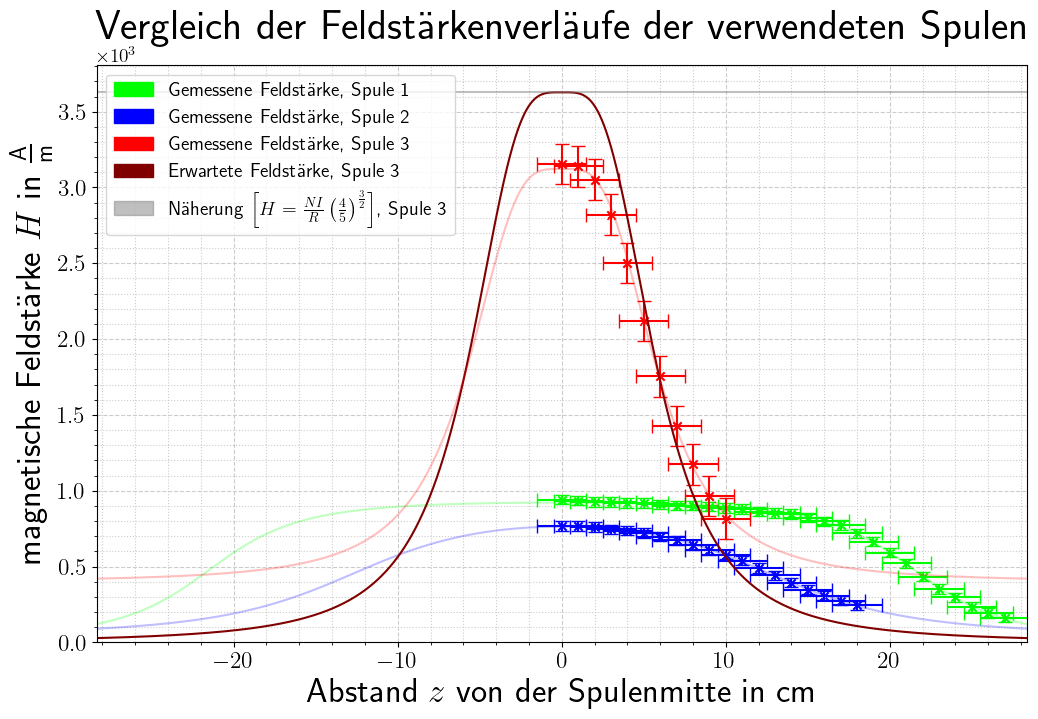

Coil 1 : [1.02750032 6.70489051 1.04677506] \pm [6.24481141e-02 5.60689875e+01 2.62235047e-02]
Offset:  2742.66527744915 \pm 6.607150103921503
Coil 1 : Estimated $H = \frac{nI}{l} = 920 \pm 40 \frac{\text A}{\text m} \: ( 4 %)$
Coil 2 : [ 0.97584498 38.8114838   1.07696008] \pm [  0.1565812  120.77620354   0.12544166]
Offset:  2748.989805325563 \pm 6.5416404409416335


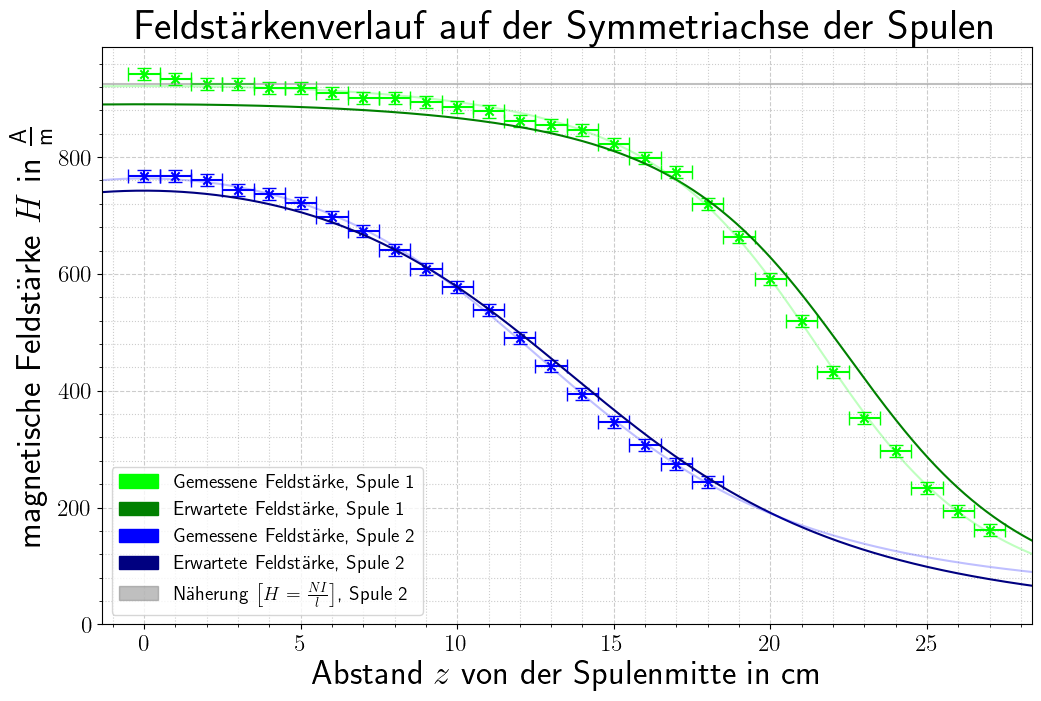

In [21]:
plot([1, 2, 3], "Title", bothSides=True, sigmaInt=1, showLitTo=[3])

In [25]:
#Notes
#TODO: Tasks

In [36]:
params, lbls = load(paramFile)
print(asLatex(params, lbls))

\begin{table}[]

    	\centering

    	\caption{CHANGE THIS LATER}
	\begin{tabular}{|l|l|l|l|l|l|l|}
		\hline
		Spulennr. & Windung n  & Lï¿½nge l in m & Durchmesser d in cm & Drahtdurchmesser in mm & ist_Helmholtz & ist_Induct \\
		\hline
		1.000000 & 832.000000 & 0.450000 & 12.550000 & 0.500000 & 0.000000 & 0.000000 \\
		2.000000 & 499.000000 & 0.270000 & 20.000000 & 0.500000 & 0.000000 & 0.000000 \\
		3.000000 & 507.000000 & 0.015000 & 10.000000 & -1.000000 & 1.000000 & 0.000000 \\
		4.000000 & 369.000000 & 0.070000 & 5.900000 & -1.000000 & 0.000000 & 1.000000 \\
		1.100000 & 832.000000 & 0.450000 & 12.550000 & 0.500000 & 0.000000 & 0.000000 \\
		\hline
		\end{tabular}
			\label{tab:my_label}
\end{table}


In [38]:
dat, lbls = load("data/someDataYooNeedTheTableTo.csv")#TODO
print(asLatex(sigFormatTable(dat, [[0, 2], [1, 3]]), lbls))#TODO: Ajust value error index paires

\begin{table}[]

    	\centering

    	\caption{CHANGE THIS LATER}
	\begin{tabular}{|l|l|}
		\hline
		Abstand $z$ von der Spulenmitte in cm & Integrierte Ladung O ~ Q \\
		\hline
		$ 0\cdot 10^{-1} \pm 5\cdot 10^{-1}$ & $ -257 \pm 1\: (\pm 0.39\%)$ \\
		$ 2.0 \pm 0.5\: (\pm 25\%)$ & $ -258 \pm 1\: (\pm 0.39\%)$ \\
		$ 4.0 \pm 0.5\: (\pm 13\%)$ & $ -253 \pm 1\: (\pm 0.4\%)$ \\
		$ 6.0 \pm 0.5\: (\pm 8.4\%)$ & $ -250 \pm 1\: (\pm 0.4\%)$ \\
		$ 8.0 \pm 0.5\: (\pm 6.3\%)$ & $ -248 \pm 1\: (\pm 0.41\%)$ \\
		$ 10.0 \pm 0.5\: (\pm 5.0\%)$ & $ -243 \pm 1\: (\pm 0.42\%)$ \\
		$ 12.0 \pm 0.5\: (\pm 4.2\%)$ & $ -232 \pm 1\: (\pm 0.44\%)$ \\
		$ 14.0 \pm 0.5\: (\pm 3.6\%)$ & $ -212 \pm 1\: (\pm 0.48\%)$ \\
		$ 16.0 \pm 0.5\: (\pm 3.2\%)$ & $ -193 \pm 1\: (\pm 0.52\%)$ \\
		$ 18.0 \pm 0.5\: (\pm 2.8\%)$ & $ -156 \pm 1\: (\pm 0.65\%)$ \\
		$ 20.0 \pm 0.5\: (\pm 2.5\%)$ & $ -118 \pm 1\: (\pm 0.85\%)$ \\
		$ 22.0 \pm 0.5\: (\pm 2.3\%)$ & $ -76 \pm 1\: (\pm 1.4\%)$ \\
		$ 24.0 \pm 0.5\: (\pm 2.1\%)$ 

In [36]:
def printFileAsLatex(path, val_err_index_pairs):
    dat, lbls = load(path)
    print(asLatex(sigFormatTable(dat, val_err_index_pairs), lbls))